## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from quantile_forest.patchwise_dataset import PatchwiseDataset
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import sklearn_quantile
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import os
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from ipyleaflet import Map, Rectangle, ImageOverlay, LayerGroup
from ipywidgets import VBox, SelectionSlider
from base64 import b64encode
from io import BytesIO
import pandas as pd
import h5py
import warnings

from quantile_forest.extract_patchwise_samples_from_cubes import add_predictions_to_h5

In [2]:
T = 438
H = 128
W = 128

In [3]:
data_path = '/Users/samanthabiegel/Documents/satanom/data/cubes_droughts/processed_maxnan36_removepct0.0_lowessfrac0.07.h5'
spatial_feature_list = ["slope", "northing", "twi", "rugg", "curv", "dem", "valid_mask"]
data = PatchwiseDataset(data_path, annual=False, pixelwise=False, spatiotemporal_features=["s2_ndvi"], spatial_features=spatial_feature_list)
train_data, test_data = torch.utils.data.random_split(data, [60, 20])

In [4]:
batch_size = 1
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)

In [5]:
train_features_list = []
train_target_list = []

for batch in tqdm(train_dataloader):
    dgs = batch['dgs']
    dgs_cos = torch.cos(2 * np.pi * dgs / 365)
    dgs_sin = torch.sin(2 * np.pi * dgs / 365)
    dgs_cos_expanded = dgs_cos.view(1, T, 1, 1, 1).expand(-1, -1, H, W, 1)
    dgs_sin_expanded = dgs_sin.view(1, T, 1, 1, 1).expand(-1, -1, H, W, 1)
    spatial_expanded = batch['spatial'][:, :, :, :6].unsqueeze(0).repeat(1, T, 1, 1, 1)
    valid_mask = batch['spatial'][:, :, :, -1].unsqueeze(0).repeat(1, T, 1, 1).unsqueeze(4)

    features = torch.cat((dgs_cos_expanded, dgs_sin_expanded, spatial_expanded), dim=-1)
    target = batch['spatiotemporal']
    target[valid_mask == 0] = np.nan
    
    features_reshaped = features.view(batch_size, -1, len(spatial_feature_list) + 1)
    target_reshaped = target.view(batch_size, -1, 1)

    train_features_list.append(features_reshaped)
    train_target_list.append(target_reshaped)

train_features_tensor = torch.cat(train_features_list, dim=1).squeeze(0)
train_target_tensor = torch.cat(train_target_list, dim=1).squeeze(0)

nan_y = torch.isnan(train_target_tensor).squeeze()
train_features_tensor = train_features_tensor[~nan_y, :]
train_target_tensor = train_target_tensor[~nan_y]

shuffle_idx = torch.randperm(train_features_tensor.size(0))
train_features_tensor = train_features_tensor[shuffle_idx]
train_target_tensor = train_target_tensor[shuffle_idx]


 43%|████▎     | 26/60 [00:02<00:03, 11.10it/s]


KeyboardInterrupt: 

In [16]:
params = dict(
    n_estimators=10,
    max_depth=3,
    min_samples_split=100, 
    min_samples_leaf=100,
    bootstrap=True,
    max_samples=0.1,
    max_features=3,
)

model = sklearn_quantile.SampleRandomForestQuantileRegressor(**params, verbose=10)
model.fit(train_features_tensor.detach().numpy(), train_target_tensor.detach().numpy())

/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training forest
building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   17.2s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.2min


building tree 5 of 10
building tree 6 of 10
building tree 7 of 10


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  2.1min


building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
Applying training samples


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   14.3s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:   25.6s


Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/utils/parallel.py:118: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    8.7s


SampleRandomForestQuantileRegressor(max_depth=3, max_features=3,
                                    max_samples=0.1, min_samples_leaf=100,
                                    min_samples_split=100, n_estimators=10,
                                    verbose=10)

In [17]:
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=0)

test_features_list = []
test_target_list = []

for batch in tqdm(test_dataloader):
    dgs = batch['dgs']
    dgs_cos = torch.cos(2 * np.pi * dgs / 365)
    dgs_sin = torch.sin(2 * np.pi * dgs / 365)
    dgs_cos_expanded = dgs_cos.view(1, T, 1, 1, 1).expand(-1, -1, H, W, 1)
    dgs_sin_expanded = dgs_sin.view(1, T, 1, 1, 1).expand(-1, -1, H, W, 1)
    spatial_expanded = batch['spatial'][:, :, :, :6].unsqueeze(0).repeat(1, T, 1, 1, 1)
    valid_mask = batch['spatial'][:, :, :, -1].unsqueeze(0).repeat(1, T, 1, 1).unsqueeze(4)

    features = torch.cat((dgs_cos_expanded, dgs_sin_expanded, spatial_expanded), dim=-1)
    target = batch['spatiotemporal']
    target[valid_mask == 0] = np.nan
    
    features_reshaped = features.view(batch_size, -1, len(spatial_feature_list) + 1)
    target_reshaped = target.view(batch_size, -1, 1)

    test_features_list.append(features_reshaped)
    test_target_list.append(target_reshaped)

test_features_tensor = torch.cat(test_features_list, dim=1).squeeze(0)
test_target_tensor = torch.cat(test_target_list, dim=1).squeeze(0)


100%|██████████| 20/20 [00:02<00:00,  7.26it/s]


In [18]:
model.q = [0.02, 0.1, 0.5, 0.9, 0.98]
preds = model.predict(test_features_tensor.detach().numpy())
preds_reshaped = preds.reshape(5, 20, 438, 128, 128, 1)

/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/utils/parallel.py:118: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   19.8s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:   38.2s


In [46]:
folder_path = "../../data/cubes_droughts/cubes"
nc_files = [f for f in os.listdir(folder_path) if f.endswith('.nc')]
cubes = [
    xr.open_dataset(os.path.join(folder_path, nc_file))
    for nc_file in nc_files
    if "_raw" not in nc_file
]

In [48]:
test_cubes = []

for i, test_data_cube in enumerate(test_data):
    lat = test_data_cube['lat']
    lon = test_data_cube['lon']
    for cube in cubes:
        lat_cube = np.array(cube['lat'].values)
        lon_cube = np.array(cube['lon'].values)
        equal_lat = np.all(np.isclose(lat, lat_cube, atol=0.00001))
        equal_lon = np.all(np.isclose(lon, lon_cube, atol=0.00001))
        if equal_lat and equal_lon:
            test_cubes.append(cube)
            print("Found matching cube for test data cube", i)
        


Found matching cube for test data cube 1
Found matching cube for test data cube 2
Found matching cube for test data cube 8


In [21]:
test_cube_preds = []
for i, test_cube in tqdm(enumerate(test_cubes)):
    test_cube = test_cube.reindex(time=data.time[0])
    for j, q in enumerate(model.q):
        test_cube[f'q{q}'] = (('time', 'lat', 'lon'), preds_reshaped[j, i, :, :, :, 0])
    is_strong_neg_anomaly = test_cube['s2_ndvi'] < test_cube['q0.02']
    is_weak_neg_anomaly = (test_cube['s2_ndvi'] >= test_cube['q0.02']) & (test_cube['s2_ndvi'] < test_cube['q0.1'])
    is_weak_pos_anomaly = (test_cube['s2_ndvi'] >= test_cube['q0.9']) & (test_cube['s2_ndvi'] < test_cube['q0.98'])
    is_strong_pos_anomaly = test_cube['s2_ndvi'] >= test_cube['q0.98']
    anomaly = np.zeros_like(test_cube['s2_ndvi'].values)
    anomaly[is_strong_neg_anomaly] = -2
    anomaly[is_weak_neg_anomaly] = -1
    anomaly[is_weak_pos_anomaly] = 1
    anomaly[is_strong_pos_anomaly] = 2
    test_cube['anomaly'] = (('time', 'lat', 'lon'), anomaly)
    test_cube_preds.append(test_cube)

20it [00:12,  1.65it/s]


In [22]:
def create_image_overlay(data, cmap, norm):
    fig, ax = plt.subplots()
    ax.imshow(data, cmap=cmap, norm=norm)
    ax.axis('off')

    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)
    img_data = b64encode(buf.read()).decode('ascii')
    return img_data

def update_image_overlay(layer_group, minicubes, time_index, cmap, norm):
    for layer, minicube in zip(layer_group.layers, minicubes):
        data_values = minicube['anomaly'].isel(time=time_index).values
        # data_values[minicube['FOREST_MASK'].squeeze().values == 0] = 0
        
        # Mask out the positive anomalies
        data_values[data_values == 1] = 0
        data_values[data_values == 2] = 0
        image_data = create_image_overlay(data_values, cmap, norm)
        layer.url = f"data:image/png;base64,{image_data}"

def calculate_map_center(cubes):
    min_lat = min(float(cube['lat'].min()) for cube in cubes)
    max_lat = max(float(cube['lat'].max()) for cube in cubes)
    min_lon = min(float(cube['lon'].min()) for cube in cubes)
    max_lon = max(float(cube['lon'].max()) for cube in cubes)
    center_lat = (min_lat + max_lat) / 2.0
    center_lon = (min_lon + max_lon) / 2.0
    return center_lat, center_lon

def create_map_with_slider(test_cube_preds):
    center_lat, center_lon = calculate_map_center(test_cube_preds)
    m = Map(center=(center_lat, center_lon), zoom=8, scroll_wheel_zoom=True)
    m.layout.height = '800px'

    layer_group_boxes = LayerGroup()
    m.add_layer(layer_group_boxes)
    layer_group_anomalies = LayerGroup()
    m.add_layer(layer_group_anomalies)

    colors = [(1, 0, 0, 1),   # Red for -2 (strong negative anomaly)
            (1, 0.5, 0, 1),   # Orange for -1 (weak negative anomaly)
            (0, 0, 0, 0),     # Transparent for 0 (no anomaly)
            (0, 0.75, 0, 1),  # Light green for 1 (weak positive anomaly)
            (0, 0.25, 0, 1)]  # Dark green for 2 (strong positive anomaly)
    cmap = ListedColormap(colors)
    norm = BoundaryNorm([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5], cmap.N)

    for minicube in test_cube_preds:
        min_lat = float(minicube['lat'].min())
        max_lat = float(minicube['lat'].max())
        min_lon = float(minicube['lon'].min())
        max_lon = float(minicube['lon'].max())

        rectangle = Rectangle(
            bounds=((min_lat, min_lon), (max_lat, max_lon)),
            color="black",
            fill_opacity=0,
            weight=1
        )
        layer_group_boxes.add_layer(rectangle)

        data_values = minicube['anomaly'].isel(time=0).values
        # data_values[minicube['FOREST_MASK'].squeeze().values == 0] = 0
        data_values[data_values == 1] = 0
        data_values[data_values == 2] = 0
        image_data = create_image_overlay(data_values, cmap, norm)

        image_overlay = ImageOverlay(
            url=f"data:image/png;base64,{image_data}",
            bounds=((min_lat, min_lon), (max_lat, max_lon)),
            opacity=0.5,
            mercator_project=True
        )
        layer_group_anomalies.add_layer(image_overlay)

    times = test_cube_preds[0]['time'].values
    time_options = [(pd.Timestamp(t).strftime('%Y-%m-%d'), i) for i, t in enumerate(times)]
    time_slider = SelectionSlider(
        options=time_options,
        description="Time",
        orientation="horizontal",
        layout={'width': '900px'}
    )

    def on_time_change(change):
        time_index = change['new']
        update_image_overlay(layer_group_anomalies, test_cube_preds, time_index, cmap, norm)

    time_slider.observe(on_time_change, names='value')

    display(VBox([time_slider, m]))

create_map_with_slider(test_cube_preds)


TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

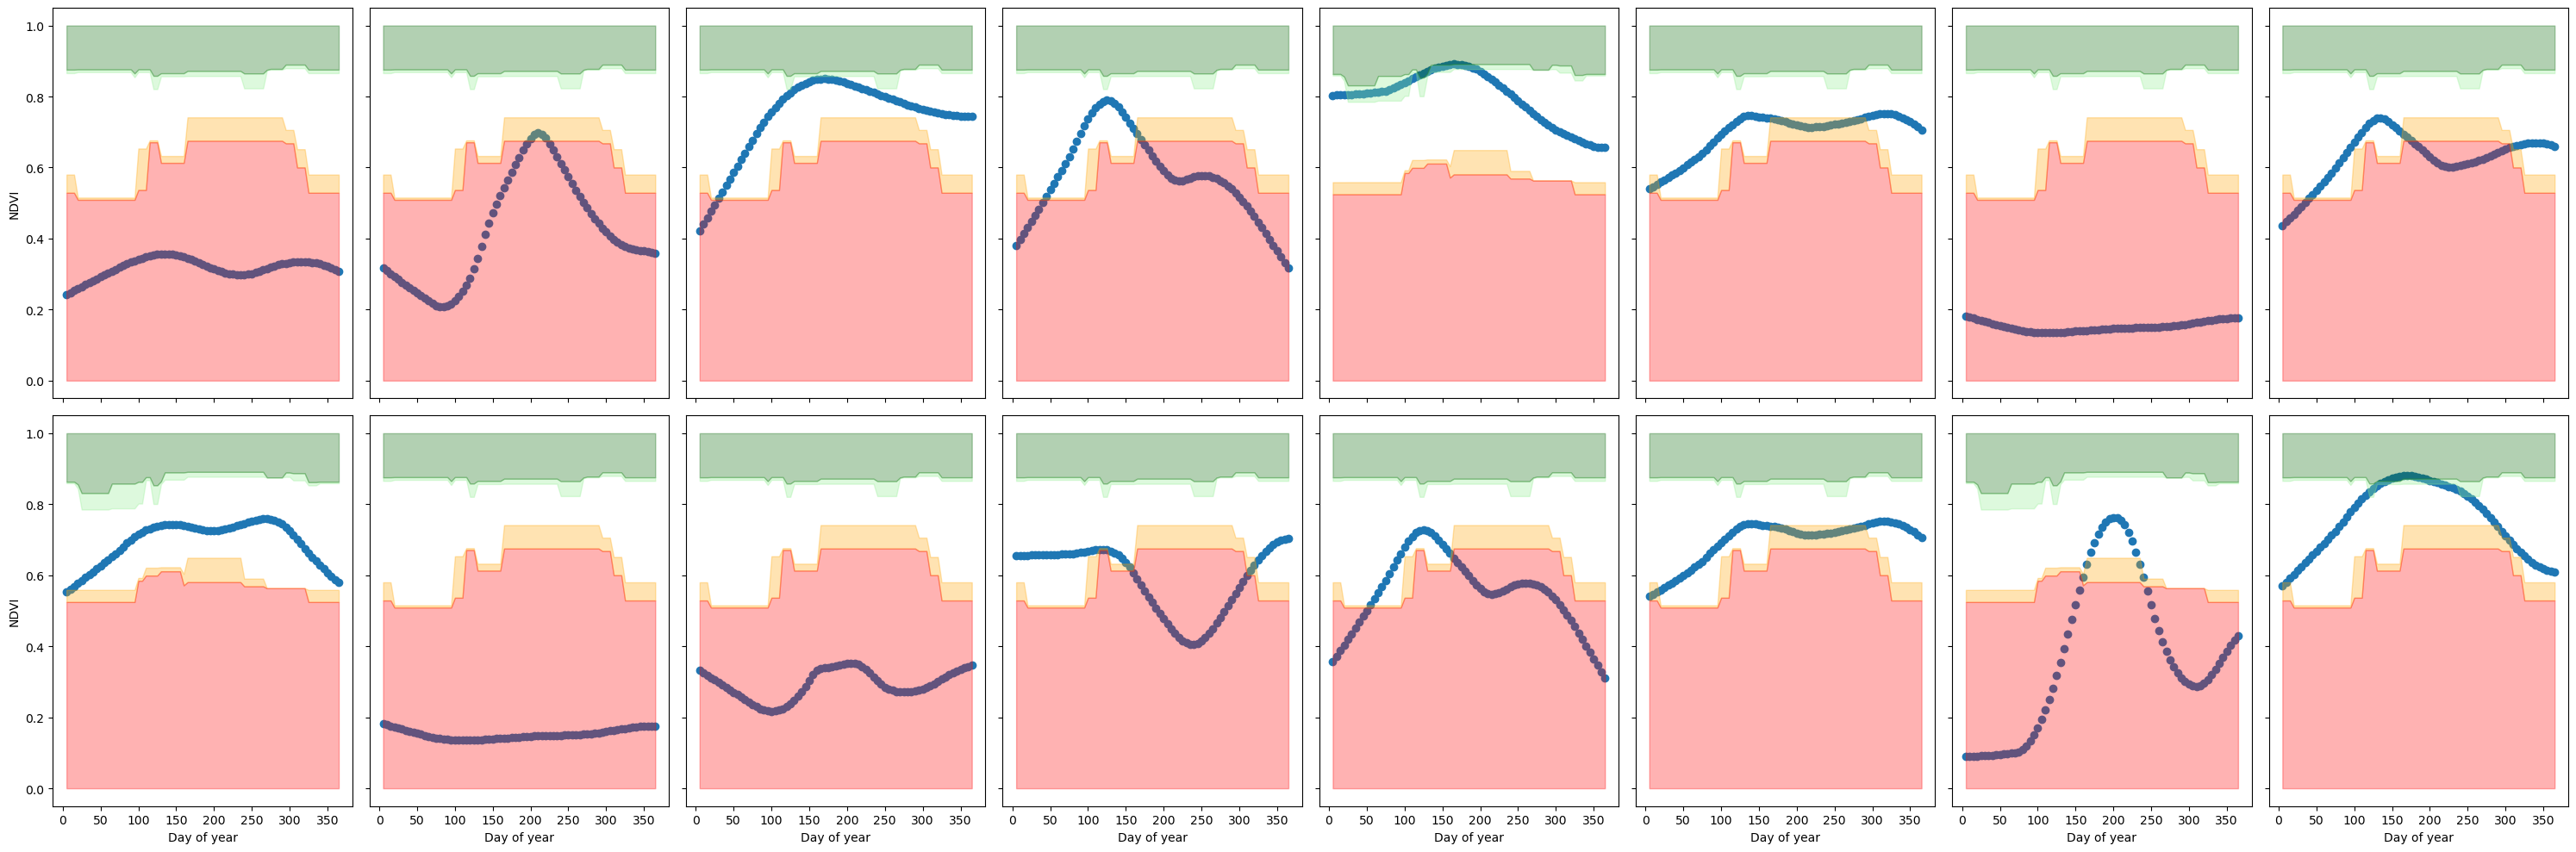

In [53]:
test_year = 2018

def plot_ndvi_quantiles(test_cube):
    time_data = test_cube['time']
    time_data_test_year = time_data.sel(time=time_data.dt.year == test_year)
    
    n_rows, n_cols = 2, 8
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 10), sharex=True, sharey=True)

    # valid_lat, valid_lon = np.where(test_cube['FOREST_MASK'].values.squeeze() == 1)
    valid_lat = np.arange(0, 128)
    valid_lon = np.arange(0, 128)

    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]

            random_pixel_idx = np.random.choice(len(valid_lon))
            random_pixel = test_cube.isel(lat=valid_lat[random_pixel_idx], lon=valid_lon[random_pixel_idx])

            pixel_ndvi = random_pixel['s2_ndvi'].sel(time=time_data_test_year).values
            pixel_time = pd.to_datetime(time_data_test_year.values).dayofyear
            
            quantile_data = {
                0.02: random_pixel['q0.02'].sel(time=time_data_test_year).values,
                0.1: random_pixel['q0.1'].sel(time=time_data_test_year).values,
                0.9: random_pixel['q0.9'].sel(time=time_data_test_year).values,
                0.98: random_pixel['q0.98'].sel(time=time_data_test_year).values,
            }

            ax.scatter(pixel_time, pixel_ndvi)

            ax.fill_between(pixel_time, quantile_data[0.02], quantile_data[0.1], color='orange', alpha=0.3)
            ax.fill_between(pixel_time, quantile_data[0.9], quantile_data[0.98], color='lightgreen', alpha=0.3)
            ax.fill_between(pixel_time, 0, quantile_data[0.02], color='red', alpha=0.3)
            ax.fill_between(pixel_time, quantile_data[0.98], 1, color='darkgreen', alpha=0.3)

            if i == n_rows - 1:
                ax.set_xlabel('Day of year')
            if j == 0:
                ax.set_ylabel('NDVI')

    plt.tight_layout()
    plt.show()

plot_ndvi_quantiles(test_cube_preds[0])


## Local model per cube

In [5]:
data_path = '/Users/samanthabiegel/Documents/satanom/data/cubes_raw_droughts/processed_maxnan36_removepct0.0.h5'
spatial_feature_list = ["slope", "northing", "twi", "rugg", "curv", "dem", "valid_mask"]
data = PatchwiseDataset(data_path, annual=False, pixelwise=False, spatiotemporal_features=["s2_ndvi", "s2_cloud_free_mask"], spatial_features=spatial_feature_list)

In [6]:
dataloader = DataLoader(data, batch_size=1, shuffle=False, num_workers=0)

In [7]:
T = 73*7
all_time_idx = np.arange(T)
test_time_idx = all_time_idx[73:2*73]
train_time_idx = np.concatenate((all_time_idx[:73], all_time_idx[2*73:]))

params = dict(
    n_estimators=20,
    max_depth=5,
    bootstrap=True,
    max_features=3,
)

In [104]:
for cube in dataloader:
    dgs = cube['dgs']
    dgs_cos = torch.cos(2 * np.pi * dgs / 365)
    dgs_sin = torch.sin(2 * np.pi * dgs / 365)
    dgs_cos_expanded = dgs_cos.view(1, T, 1, 1, 1).expand(-1, -1, H, W, 1)
    dgs_sin_expanded = dgs_sin.view(1, T, 1, 1, 1).expand(-1, -1, H, W, 1)
    spatial_expanded = cube['spatial'][:, :, :, :6].unsqueeze(0).repeat(1, T, 1, 1, 1)
    valid_mask = cube['spatial'][:, :, :, -1].unsqueeze(0).repeat(1, T, 1, 1).unsqueeze(4)

    features = torch.cat((dgs_cos_expanded, dgs_sin_expanded, spatial_expanded), dim=-1)
    
    train_target = cube['spatiotemporal']
    train_target[valid_mask == 0] = np.nan
    
    train_features = features[:, train_time_idx, :, :, :]
    train_features_reshaped = train_features.view(batch_size, -1, len(spatial_feature_list) + 1)
    train_target = train_target[:, train_time_idx, :, :, :]
    train_target_reshaped = train_target.view(batch_size, -1, 1)

    nan_y = torch.isnan(train_target_reshaped).squeeze(2)
    not_nan_y = ~nan_y
    train_features_reshaped = train_features_reshaped[~nan_y, :]
    train_target_reshaped = train_target_reshaped[~nan_y]

    test_features = features[:, test_time_idx, :, :, :]
    test_features_reshaped = test_features.view(batch_size, -1, len(spatial_feature_list) + 1).squeeze(0)

    model = sklearn_quantile.SampleRandomForestQuantileRegressor(**params, verbose=10)
    model.fit(train_features_reshaped.detach().numpy(), train_target_reshaped.detach().numpy())

    model.q = [0.02, 0.1, 0.5, 0.9, 0.98]
    preds = model.predict(test_features_reshaped.detach().numpy())
    preds_reshaped = preds.reshape(len(model.q), 73, 128, 128)

    anomalies = np.zeros_like(preds_reshaped[0, :, :, :])
    ndvi_2018 = cube['spatiotemporal'].squeeze().numpy()[73:2*73, :, :]
    is_strong_neg_anomaly = ndvi_2018 < preds_reshaped[0, :, :, :]
    is_weak_neg_anomaly = (ndvi_2018 >= preds_reshaped[0, :, :, :]) & (ndvi_2018 < preds_reshaped[1, :, :, :])
    is_weak_pos_anomaly = (ndvi_2018 >= preds_reshaped[3, :, :, :]) & (ndvi_2018 < preds_reshaped[4, :, :, :])
    is_strong_pos_anomaly = ndvi_2018 >= preds_reshaped[4, :, :, :]
    anomalies[is_strong_neg_anomaly] = -2
    anomalies[is_weak_neg_anomaly] = -1
    anomalies[is_weak_pos_anomaly] = 1
    anomalies[is_strong_pos_anomaly] = 2

    lat = cube['lat'].squeeze().numpy()
    lon = cube['lon'].squeeze().numpy()
    time = data.time[0][:73]

    ds = xr.Dataset(
        {
            'anomaly': (['time', 'lat', 'lon'], anomalies),
            'lat': (['lat'], lat),
            'lon': (['lon'], lon),
            'time': (['time'], time)
        }
    )

    ds.to_netcdf(f"/Users/samanthabiegel/Documents/satanom/data/cubes_raw_droughts/anomalies_2018_{cube['lat'].squeeze().numpy()[0]}_{cube['lon'].squeeze().numpy()[0]}.nc")

IndexError: The shape of the mask [1, 511, 128, 128, 1] at index 4 does not match the shape of the indexed tensor [1, 511, 128, 128, 2] at index 4

In [28]:
nc_files_anomalies = [f for f in os.listdir("/Users/samanthabiegel/Documents/satanom/data/cubes_raw_droughts") if f.startswith('anomalies')]
cubes_anomalies = [
    xr.open_dataset(os.path.join("/Users/samanthabiegel/Documents/satanom/data/cubes_raw_droughts", nc_file))
    for nc_file in nc_files_anomalies
]

In [29]:
create_map_with_slider(cubes_anomalies)

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

TypeError: update_image_overlay() missing 3 required positional arguments: 'current_map_bounds', 'all_cube_bounds', and 'zoom_level'

## Loading preds with H5 file + tune hyperparameters

In [110]:
param_grid = dict(
    n_estimators=[10, 20, 50, 100],
    max_depth=[3, 5, 7, 10, 15],
    min_samples_split=[10, 50, 100, 200],
    min_samples_leaf=[10, 20, 50, 100],
    max_samples=[0.1, 0.2, 0.3, 0.5, 0.7, 1.0],
    max_features=[3, 5, 7],
)

In [119]:
warnings.filterwarnings("ignore", category=FutureWarning, message="Function delayed is deprecated")
warnings.filterwarnings("ignore", category=UserWarning, message="`sklearn.utils.parallel.delayed` should be used")

for i, cube in enumerate(dataloader):
    dgs = cube['dgs']
    dgs_cos = torch.cos(2 * np.pi * dgs / 365)
    dgs_sin = torch.sin(2 * np.pi * dgs / 365)
    dgs_cos_expanded = dgs_cos.view(1, T, 1, 1, 1).expand(-1, -1, H, W, 1)
    dgs_sin_expanded = dgs_sin.view(1, T, 1, 1, 1).expand(-1, -1, H, W, 1)
    spatial_expanded = cube['spatial'][:, :, :, :6].unsqueeze(0).repeat(1, T, 1, 1, 1)
    valid_mask = cube['spatial'][:, :, :, -1].unsqueeze(0).repeat(1, T, 1, 1).unsqueeze(4)
    cloud_mask = cube['spatiotemporal'][:, :, :, :, 1][:, :, :, :, np.newaxis]

    features = torch.cat((dgs_cos_expanded, dgs_sin_expanded, spatial_expanded), dim=-1)
    
    train_target = cube['spatiotemporal'][:, :, :, :, 0][:, :, :, :, np.newaxis]
    train_target[cloud_mask == 0] = np.nan
    train_target[valid_mask == 0] = np.nan
    
    train_features = features[:, train_time_idx, :, :, :]
    train_features_reshaped = train_features.view(batch_size, -1, len(spatial_feature_list) + 1)
    train_target = train_target[:, train_time_idx, :, :, :]
    train_target_reshaped = train_target.view(batch_size, -1, 1)

    nan_y = torch.isnan(train_target_reshaped).squeeze(2)
    not_nan_y = ~nan_y
    train_features_reshaped = train_features_reshaped[~nan_y, :]
    train_target_reshaped = train_target_reshaped[~nan_y]

    train_target_reshaped = train_target_reshaped.squeeze()

    test_features = features[:, test_time_idx, :, :, :]
    test_features_reshaped = test_features.view(batch_size, -1, len(spatial_feature_list) + 1).squeeze(0)

    best_oob_score = 0
    for j in tqdm(range(20)):
        sampled_params = {key: np.random.choice(value) for key, value in param_grid.items()}
        model = sklearn_quantile.SampleRandomForestQuantileRegressor(**sampled_params, oob_score=True, verbose=0)
        model.q = [0.02, 0.1, 0.5, 0.9, 0.98]
        model.fit(train_features_reshaped.detach().numpy(), train_target_reshaped.detach().numpy())
        oob_score = model.oob_score_
        if oob_score > best_oob_score:
            best_oob_score = oob_score
            best_params = sampled_params

    print("Best parameters:", best_params)
    print("OOB score of best model:", oob_score)

    best_model = sklearn_quantile.SampleRandomForestQuantileRegressor(**best_params, verbose=0)
    best_model.q = [0.02, 0.1, 0.5, 0.9, 0.98]
    best_model.fit(train_features_reshaped.detach().numpy(), train_target_reshaped.detach().numpy())
    preds = best_model.predict(test_features_reshaped.detach().numpy())
    preds_reshaped = preds.reshape(len(model.q), 73, 128, 128)

    anomalies = np.zeros_like(preds_reshaped[0, :, :, :])
    ndvi_2018 = cube['spatiotemporal'][:, :, :, :, 0].squeeze().numpy()[test_time_idx, :, :]
    is_strong_neg_anomaly = ndvi_2018 < preds_reshaped[0, :, :, :]
    is_weak_neg_anomaly = (ndvi_2018 >= preds_reshaped[0, :, :, :]) & (ndvi_2018 < preds_reshaped[1, :, :, :])
    is_weak_pos_anomaly = (ndvi_2018 >= preds_reshaped[3, :, :, :]) & (ndvi_2018 < preds_reshaped[4, :, :, :])
    is_strong_pos_anomaly = ndvi_2018 >= preds_reshaped[4, :, :, :]
    anomalies[is_strong_neg_anomaly] = -2
    anomalies[is_weak_neg_anomaly] = -1
    anomalies[is_weak_pos_anomaly] = 1
    anomalies[is_strong_pos_anomaly] = 2
    anomalies = anomalies[np.newaxis, :, :, :]

    with h5py.File(data_path, 'r') as f:
        if 'anomalies_qrf_percube_2018' in f['preds'] and i==0:
            del f['preds']['anomalies_qrf_percube_2018']
            del f['preds']['q0.02_qrf_percube_2018']
            del f['preds']['q0.1_qrf_percube_2018']
            del f['preds']['q0.9_qrf_percube_2018']
            del f['preds']['q0.98_qrf_percube_2018']

    add_predictions_to_h5(dataloader.dataset.file, anomalies, "anomalies_qrf_percube_2018")
    add_predictions_to_h5(dataloader.dataset.file, preds_reshaped[0, :, :, :][np.newaxis, :, :, :], "q0.02_qrf_percube_2018")
    add_predictions_to_h5(dataloader.dataset.file, preds_reshaped[1, :, :, :][np.newaxis, :, :, :], "q0.1_qrf_percube_2018")
    add_predictions_to_h5(dataloader.dataset.file, preds_reshaped[3, :, :, :][np.newaxis, :, :, :], "q0.9_qrf_percube_2018")
    add_predictions_to_h5(dataloader.dataset.file, preds_reshaped[4, :, :, :][np.newaxis, :, :, :], "q0.98_qrf_percube_2018")

  0%|          | 0/20 [00:00<?, ?it/s]

Sampling trees


 10%|█         | 2/20 [01:25<10:39, 35.53s/it]

Sampling trees
Sampling trees


 20%|██        | 4/20 [02:03<06:12, 23.26s/it]

Sampling trees
Sampling trees


 30%|███       | 6/20 [03:33<07:32, 32.35s/it]

Sampling trees


 35%|███▌      | 7/20 [03:36<04:56, 22.79s/it]

Sampling trees


 40%|████      | 8/20 [03:46<03:47, 18.99s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 45%|████▌     | 9/20 [03:53<02:44, 14.96s/it]

Sampling trees
Sampling trees


 55%|█████▌    | 11/20 [05:54<05:46, 38.47s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 60%|██████    | 12/20 [06:00<03:46, 28.36s/it]

Sampling trees
Sampling trees


 70%|███████   | 14/20 [07:34<03:36, 36.00s/it]

Sampling trees


 75%|███████▌  | 15/20 [08:22<03:17, 39.49s/it]

Sampling trees
Sampling trees


 80%|████████  | 16/20 [09:04<02:41, 40.32s/it]

Sampling trees


 85%|████████▌ | 17/20 [10:37<02:48, 56.20s/it]

Sampling trees


 95%|█████████▌| 19/20 [12:13<00:47, 47.98s/it]

Sampling trees


100%|██████████| 20/20 [12:41<00:00, 38.10s/it]

Sampling trees
Best parameters: {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_samples': 0.5, 'max_features': 5}
OOB score of best model: 0.8954855558046304


Sampling trees


  0%|          | 0/20 [00:00<?, ?it/s]

Sampling trees


  5%|▌         | 1/20 [00:22<07:11, 22.71s/it]/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 10%|█         | 2/20 [00:24<03:07, 10.43s/it]

Sampling trees


 15%|█▌        | 3/20 [00:49<04:53, 17.27s/it]

Sampling trees


 20%|██        | 4/20 [01:01<04:00, 15.02s/it]

Sampling trees


 25%|██▌       | 5/20 [01:04<02:39, 10.64s/it]

Sampling trees
Sampling trees


 35%|███▌      | 7/20 [01:35<02:40, 12.31s/it]

Sampling trees


 40%|████      | 8/20 [02:13<04:06, 20.53s/it]

Sampling trees


 45%|████▌     | 9/20 [03:01<05:22, 29.32s/it]

Sampling trees
Sampling trees


 55%|█████▌    | 11/20 [03:43<03:36, 24.01s/it]

Sampling trees
Sampling trees


 60%|██████    | 12/20 [04:06<03:10, 23.76s/it]

Sampling trees


 70%|███████   | 14/20 [04:53<02:12, 22.08s/it]

Sampling trees
Sampling trees


 80%|████████  | 16/20 [05:51<01:32, 23.22s/it]

Sampling trees


 85%|████████▌ | 17/20 [06:02<00:59, 19.77s/it]

Sampling trees


 90%|█████████ | 18/20 [06:26<00:41, 20.89s/it]

Sampling trees


 95%|█████████▌| 19/20 [06:30<00:15, 15.90s/it]

Sampling trees


100%|██████████| 20/20 [07:00<00:00, 21.03s/it]

Sampling trees
Best parameters: {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_samples': 0.2, 'max_features': 7}
OOB score of best model: 0.8030709157011523


Sampling trees


  5%|▌         | 1/20 [00:02<00:56,  2.95s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 10%|█         | 2/20 [00:07<01:11,  3.95s/it]

Sampling trees


 15%|█▌        | 3/20 [00:09<00:53,  3.16s/it]

Sampling trees


 20%|██        | 4/20 [00:46<04:20, 16.31s/it]

Sampling trees


 25%|██▌       | 5/20 [00:54<03:20, 13.39s/it]

Sampling trees


 30%|███       | 6/20 [00:58<02:23, 10.23s/it]

Sampling trees


 35%|███▌      | 7/20 [01:23<03:15, 15.04s/it]

Sampling trees


 40%|████      | 8/20 [02:25<06:01, 30.10s/it]

Sampling trees


 45%|████▌     | 9/20 [02:28<03:56, 21.53s/it]

Sampling trees


 50%|█████     | 10/20 [02:34<02:46, 16.65s/it]

Sampling trees


 55%|█████▌    | 11/20 [02:37<01:52, 12.48s/it]

Sampling trees


 60%|██████    | 12/20 [02:59<02:02, 15.37s/it]

Sampling trees


 65%|██████▌   | 13/20 [03:01<01:20, 11.44s/it]

Sampling trees


 70%|███████   | 14/20 [04:04<02:42, 27.09s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 75%|███████▌  | 15/20 [04:13<01:47, 21.58s/it]

Sampling trees


 80%|████████  | 16/20 [04:15<01:02, 15.59s/it]

Sampling trees


 85%|████████▌ | 17/20 [04:22<00:39, 13.01s/it]

Sampling trees


 90%|█████████ | 18/20 [04:26<00:20, 10.26s/it]

Sampling trees


 95%|█████████▌| 19/20 [04:27<00:07,  7.57s/it]

Sampling trees


100%|██████████| 20/20 [04:34<00:00, 13.71s/it]

Sampling trees
Best parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 100, 'min_samples_leaf': 20, 'max_samples': 1.0, 'max_features': 5}
OOB score of best model: 0.7325310057494081


Sampling trees


  5%|▌         | 1/20 [00:07<02:20,  7.39s/it]

Sampling trees


 10%|█         | 2/20 [00:11<01:40,  5.58s/it]

Sampling trees
Sampling trees


 15%|█▌        | 3/20 [00:51<06:04, 21.42s/it]/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 20%|██        | 4/20 [00:55<03:51, 14.44s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 25%|██▌       | 5/20 [01:04<03:04, 12.27s/it]

Sampling trees


 30%|███       | 6/20 [01:21<03:15, 13.96s/it]

Sampling trees


 35%|███▌      | 7/20 [01:32<02:51, 13.19s/it]

Sampling trees


 40%|████      | 8/20 [01:51<02:57, 14.79s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 45%|████▌     | 9/20 [01:54<02:04, 11.29s/it]

Sampling trees
Sampling trees


 50%|█████     | 10/20 [02:53<04:19, 25.91s/it]

Sampling trees


 60%|██████    | 12/20 [04:46<04:59, 37.40s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 65%|██████▌   | 13/20 [04:56<03:21, 28.84s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 70%|███████   | 14/20 [04:59<02:07, 21.27s/it]

Sampling trees


 75%|███████▌  | 15/20 [05:02<01:19, 15.82s/it]

Sampling trees


 80%|████████  | 16/20 [05:05<00:46, 11.70s/it]

Sampling trees


 85%|████████▌ | 17/20 [05:17<00:35, 11.99s/it]

Sampling trees


 90%|█████████ | 18/20 [05:28<00:23, 11.57s/it]

Sampling trees
Sampling trees


 95%|█████████▌| 19/20 [07:44<00:49, 49.08s/it]/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
100%|██████████| 20/20 [08:04<00:00, 24.23s/it]

Sampling trees
Best parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 100, 'min_samples_leaf': 20, 'max_samples': 0.7, 'max_features': 7}
OOB score of best model: 0.8464090706717913


Sampling trees


  0%|          | 0/20 [00:00<?, ?it/s]

Sampling trees


  5%|▌         | 1/20 [00:52<16:39, 52.61s/it]/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 10%|█         | 2/20 [01:09<09:33, 31.87s/it]

Sampling trees
Sampling trees


 15%|█▌        | 3/20 [01:17<05:54, 20.85s/it]

Sampling trees


 25%|██▌       | 5/20 [03:04<08:51, 35.41s/it]

Sampling trees


 30%|███       | 6/20 [03:11<05:59, 25.70s/it]

Sampling trees
Sampling trees


 35%|███▌      | 7/20 [06:05<16:01, 73.97s/it]

Sampling trees


 40%|████      | 8/20 [06:41<12:25, 62.15s/it]/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 45%|████▌     | 9/20 [07:20<10:00, 54.63s/it]

Sampling trees
Sampling trees


 55%|█████▌    | 11/20 [09:18<07:55, 52.82s/it]

Sampling trees


 60%|██████    | 12/20 [09:25<05:11, 38.92s/it]

Sampling trees
Sampling trees


 65%|██████▌   | 13/20 [10:30<05:28, 46.95s/it]/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 70%|███████   | 14/20 [10:36<03:27, 34.60s/it]

Sampling trees
Sampling trees


 75%|███████▌  | 15/20 [15:15<09:01, 108.29s/it]

Sampling trees


 80%|████████  | 16/20 [17:00<07:08, 107.21s/it]

Sampling trees


 85%|████████▌ | 17/20 [17:39<04:20, 86.81s/it] /Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 90%|█████████ | 18/20 [18:04<02:16, 68.09s/it]

Sampling trees
Sampling trees


100%|██████████| 20/20 [18:37<00:00, 55.89s/it]

Sampling trees
Best parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 50, 'min_samples_leaf': 50, 'max_samples': 0.5, 'max_features': 7}
OOB score of best model: 0.8429668448013347


Sampling trees


  0%|          | 0/20 [00:00<?, ?it/s]

Sampling trees


 10%|█         | 2/20 [01:38<12:32, 41.78s/it]

Sampling trees


 15%|█▌        | 3/20 [01:50<07:56, 28.01s/it]

Sampling trees
Sampling trees


 25%|██▌       | 5/20 [04:02<11:15, 45.04s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 30%|███       | 6/20 [04:11<07:37, 32.69s/it]

Sampling trees
Sampling trees


 35%|███▌      | 7/20 [05:22<09:46, 45.10s/it]

Sampling trees


 40%|████      | 8/20 [06:41<11:11, 55.92s/it]/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 45%|████▌     | 9/20 [07:12<08:49, 48.14s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 50%|█████     | 10/20 [07:43<07:09, 42.92s/it]

Sampling trees


 55%|█████▌    | 11/20 [07:49<04:44, 31.66s/it]

Sampling trees


 60%|██████    | 12/20 [08:10<03:47, 28.44s/it]

Sampling trees
Sampling trees


 65%|██████▌   | 13/20 [08:59<04:02, 34.59s/it]/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 70%|███████   | 14/20 [09:03<02:33, 25.52s/it]

Sampling trees
Sampling trees


 80%|████████  | 16/20 [10:24<02:02, 30.58s/it]

Sampling trees
Sampling trees


 85%|████████▌ | 17/20 [12:46<03:12, 64.15s/it]

Sampling trees


 90%|█████████ | 18/20 [15:01<02:51, 85.58s/it]

Sampling trees


100%|██████████| 20/20 [15:31<00:00, 46.60s/it]

Sampling trees
Best parameters: {'n_estimators': 20, 'max_depth': 15, 'min_samples_split': 50, 'min_samples_leaf': 10, 'max_samples': 0.2, 'max_features': 5}
OOB score of best model: 0.8433488079831496


Sampling trees


  5%|▌         | 1/20 [00:10<03:25, 10.82s/it]

Sampling trees


 10%|█         | 2/20 [00:11<01:31,  5.09s/it]

Sampling trees


 15%|█▌        | 3/20 [00:12<00:49,  2.90s/it]

Sampling trees


 20%|██        | 4/20 [00:14<00:40,  2.52s/it]

Sampling trees


 25%|██▌       | 5/20 [00:16<00:35,  2.34s/it]

Sampling trees


 30%|███       | 6/20 [00:20<00:40,  2.91s/it]

Sampling trees


 35%|███▌      | 7/20 [00:22<00:35,  2.71s/it]

Sampling trees


 40%|████      | 8/20 [00:23<00:25,  2.15s/it]

Sampling trees


 45%|████▌     | 9/20 [00:27<00:30,  2.77s/it]

Sampling trees


 50%|█████     | 10/20 [00:32<00:34,  3.41s/it]

Sampling trees


 55%|█████▌    | 11/20 [00:34<00:26,  2.94s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 60%|██████    | 12/20 [00:35<00:18,  2.34s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 65%|██████▌   | 13/20 [00:37<00:15,  2.20s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 70%|███████   | 14/20 [00:38<00:11,  1.98s/it]

Sampling trees


 75%|███████▌  | 15/20 [00:38<00:07,  1.50s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 80%|████████  | 16/20 [00:39<00:05,  1.32s/it]

Sampling trees


 85%|████████▌ | 17/20 [00:43<00:06,  2.06s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 90%|█████████ | 18/20 [00:44<00:03,  1.59s/it]

Sampling trees


 95%|█████████▌| 19/20 [00:48<00:02,  2.28s/it]

Sampling trees


100%|██████████| 20/20 [00:48<00:00,  2.43s/it]

Sampling trees
Best parameters: {'n_estimators': 20, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_samples': 0.1, 'max_features': 5}
OOB score of best model: 0.6685616731407149


Sampling trees


  0%|          | 0/20 [00:00<?, ?it/s]

Sampling trees


  5%|▌         | 1/20 [01:18<24:49, 78.37s/it]

Sampling trees


 10%|█         | 2/20 [01:51<15:32, 51.81s/it]/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 15%|█▌        | 3/20 [01:57<08:47, 31.04s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 20%|██        | 4/20 [02:10<06:21, 23.83s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 25%|██▌       | 5/20 [02:32<05:48, 23.22s/it]

Sampling trees
Sampling trees


 30%|███       | 6/20 [04:00<10:29, 44.99s/it]

Sampling trees


 35%|███▌      | 7/20 [04:48<09:58, 46.05s/it]

Sampling trees


 40%|████      | 8/20 [06:36<13:11, 65.95s/it]/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 45%|████▌     | 9/20 [07:03<09:49, 53.63s/it]

Sampling trees
Sampling trees


 50%|█████     | 10/20 [07:21<07:07, 42.73s/it]/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 55%|█████▌    | 11/20 [07:34<05:01, 33.56s/it]

Sampling trees
Sampling trees


 60%|██████    | 12/20 [08:33<05:30, 41.27s/it]

Sampling trees


 65%|██████▌   | 13/20 [11:46<10:11, 87.40s/it]

Sampling trees


 70%|███████   | 14/20 [12:03<06:36, 66.14s/it]/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 75%|███████▌  | 15/20 [12:13<04:05, 49.11s/it]

Sampling trees
Sampling trees


 80%|████████  | 16/20 [13:06<03:21, 50.30s/it]/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 85%|████████▌ | 17/20 [13:25<02:02, 40.98s/it]

Sampling trees


 90%|█████████ | 18/20 [13:31<01:00, 30.32s/it]

Sampling trees


/Users/samanthabiegel/miniconda3/envs/dimpeo/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 95%|█████████▌| 19/20 [13:37<00:23, 23.11s/it]

Sampling trees
Sampling trees


100%|██████████| 20/20 [14:21<00:00, 43.06s/it]


Best parameters: {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 100, 'min_samples_leaf': 20, 'max_samples': 1.0, 'max_features': 7}
OOB score of best model: 0.8240135140438473
Sampling trees


In [8]:
def create_image_overlay(data, cmap, norm):
    fig, ax = plt.subplots()
    ax.imshow(data, cmap=cmap, norm=norm)
    ax.axis('off')

    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)
    img_data = b64encode(buf.read()).decode('ascii')
    return img_data

def update_image_overlay(layer_group, preds, cloud_mask, time_index, cmap, norm, current_map_bounds, all_cube_bounds, zoom_level):
    if zoom_level > 12:
        for i, layer in enumerate(layer_group.layers):
            if (current_map_bounds['min_lat'] < all_cube_bounds[i]['max_lat'] and
                current_map_bounds['max_lat'] > all_cube_bounds[i]['min_lat'] and
                current_map_bounds['min_lon'] < all_cube_bounds[i]['max_lon'] and
                current_map_bounds['max_lon'] > all_cube_bounds[i]['min_lon']):
            
                data_values = preds[i, time_index, :, :]
                cloud_mask_values = cloud_mask[i, time_index, :, :]
                data_values[cloud_mask_values == 0] = np.nan
                
                # Mask out the positive anomalies
                # data_values[data_values == 1] = 0
                # data_values[data_values == 2] = 0
                image_data = create_image_overlay(data_values, cmap, norm)
                layer.url = f"data:image/png;base64,{image_data}"

def create_map_with_slider_h5(data_path, key, year='2018'):
    f = h5py.File(data_path, 'r')
    latitudes = f.get('meta/latitude')[:]
    longitudes = f.get('meta/longitude')[:]
    center_lat, center_lon = latitudes.mean(), longitudes.mean()

    time_data = f['temporal/time'][0]
    decoded_times = [bytes(item).decode('utf-8') for item in time_data]
    times = [item for item in decoded_times if year in item]

    m = Map(center=(center_lat, center_lon), zoom=8, scroll_wheel_zoom=True)
    m.layout.height = '800px'

    layer_group_boxes = LayerGroup()
    m.add_layer(layer_group_boxes)
    layer_group_anomalies = LayerGroup()
    m.add_layer(layer_group_anomalies)

    colors = [(1, 0, 0, 1),   # Red for -2 (strong negative anomaly)
            (1, 0.5, 0, 1),   # Orange for -1 (weak negative anomaly)
            (0, 0, 0, 0),     # Transparent for 0 (no anomaly)
            (0, 0.75, 0, 1),  # Light green for 1 (weak positive anomaly)
            (0, 0.25, 0, 1)]  # Dark green for 2 (strong positive anomaly)
    cmap = ListedColormap(colors)
    norm = BoundaryNorm([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5], cmap.N)

    preds = f.get(f"preds/{key}")
    cloud_mask = f.get('spatiotemporal/s2_cloud_free_mask')

    cube_bounds = []

    for i in range(preds.shape[0]):
        min_lat = float(latitudes[i].min())
        max_lat = float(latitudes[i].max())
        min_lon = float(longitudes[i].min())
        max_lon = float(longitudes[i].max())

        cube_bounds.append({
            'min_lat': min_lat,
            'max_lat': max_lat,
            'min_lon': min_lon,
            'max_lon': max_lon
        })
        
        rectangle = Rectangle(
            bounds=((min_lat, min_lon), (max_lat, max_lon)),
            color="black",
            fill_opacity=0,
            weight=1
        )
        layer_group_boxes.add_layer(rectangle)

        data_values = preds[i, 0, :, :]
        cloud_mask_values = cloud_mask[i, 0, :, :]
        data_values[cloud_mask_values == 0] = np.nan
        # data_values[data_values == 1] = 0
        # data_values[data_values == 2] = 0
        image_data = create_image_overlay(data_values, cmap, norm)

        image_overlay = ImageOverlay(
            url=f"data:image/png;base64,{image_data}",
            bounds=((min_lat, min_lon), (max_lat, max_lon)),
            opacity=0.5,
            mercator_project=True
        )
        layer_group_anomalies.add_layer(image_overlay)

    time_options = [(pd.Timestamp(t).strftime('%Y-%m-%d'), i) for i, t in enumerate(times)]
    time_slider = SelectionSlider(
        options=time_options,
        description="Time",
        orientation="horizontal",
        layout={'width': '900px'}
    )

    def on_time_change(change):
        time_index = change['new']
        map_bounds = m.bounds
        current_map_bounds = {
            'min_lat': map_bounds[0][0],
            'max_lat': map_bounds[1][0],
            'min_lon': map_bounds[0][1],
            'max_lon': map_bounds[1][1],
        }
        update_image_overlay(layer_group_anomalies, preds, cloud_mask, time_index, cmap, norm, current_map_bounds, cube_bounds, m.zoom)

    time_slider.observe(on_time_change, names='value')

    display(VBox([time_slider, m]))


create_map_with_slider_h5(data_path, "anomalies_qrf_percube_2018")


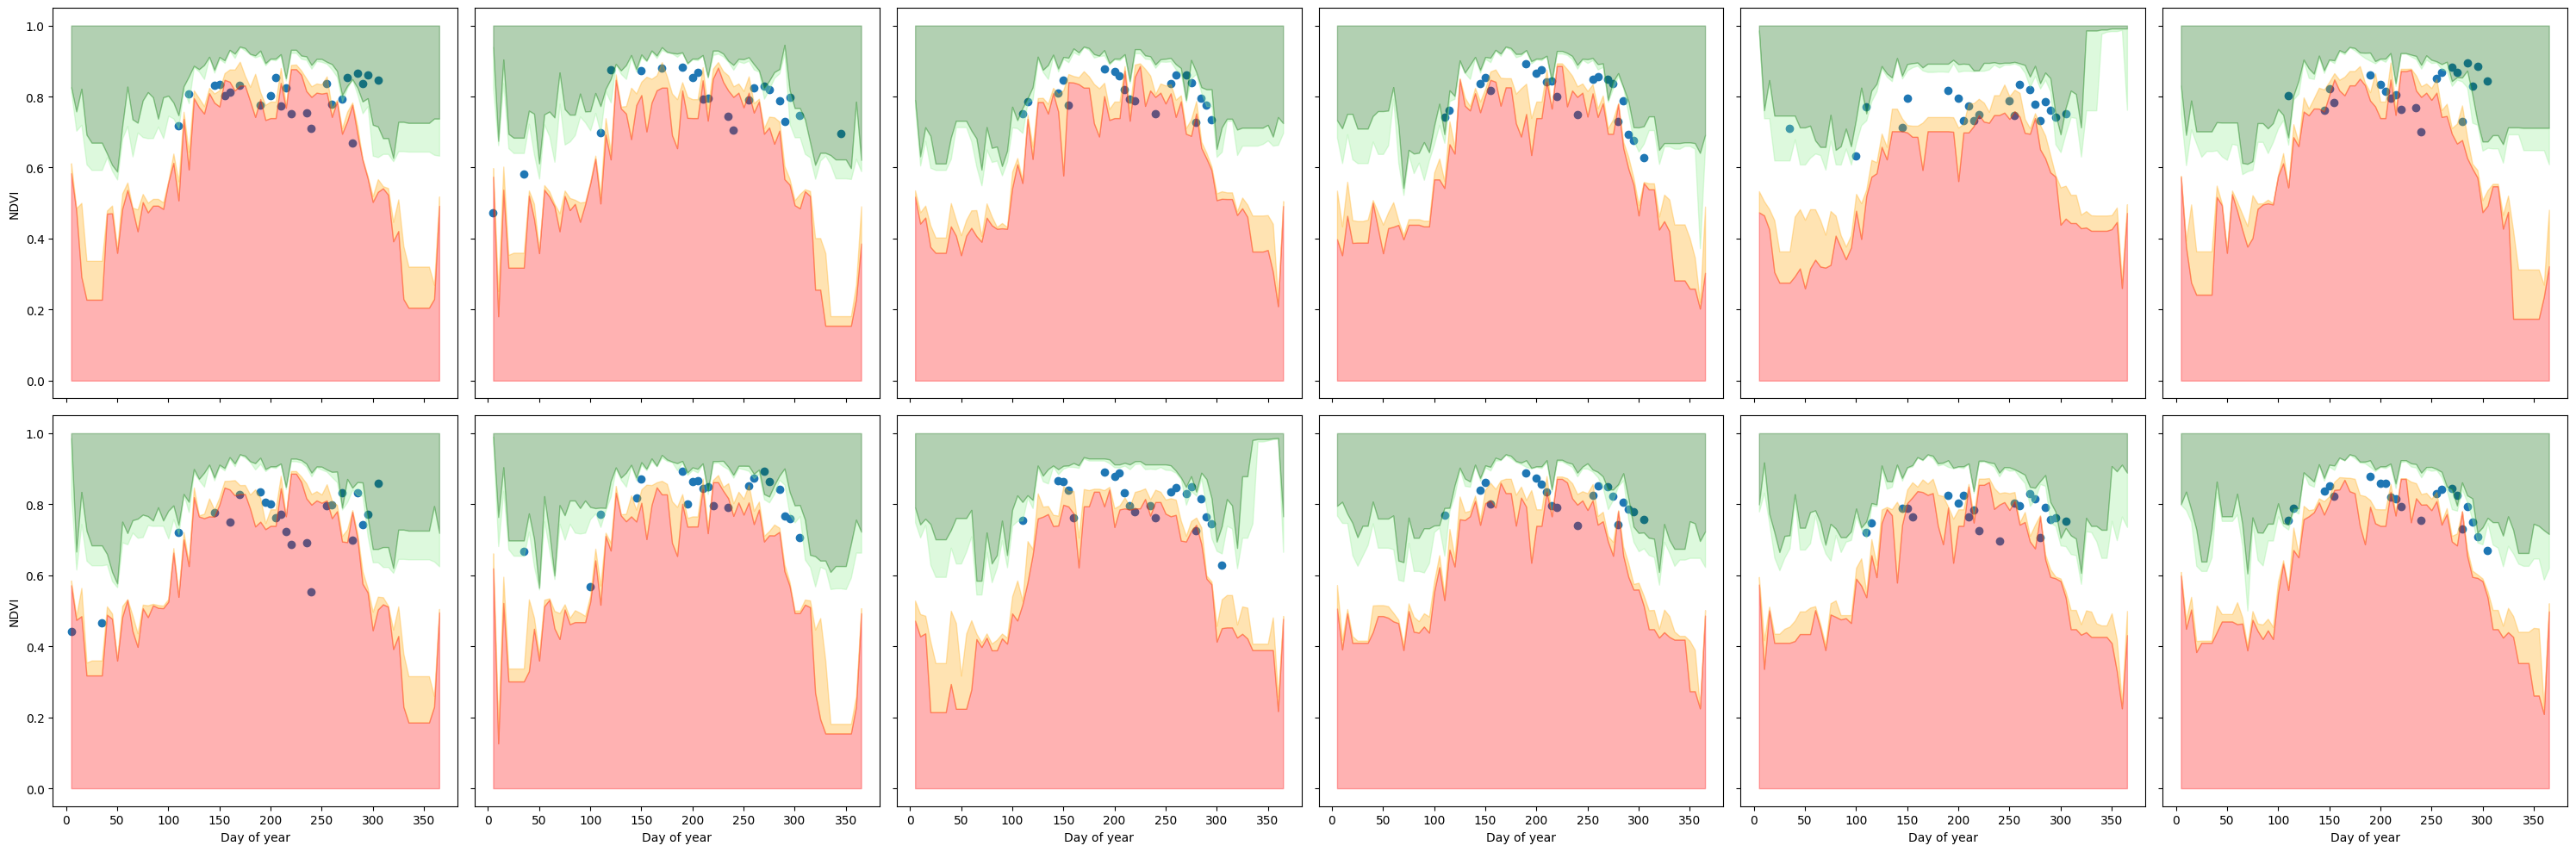

In [9]:
test_year = 2018

def plot_ndvi_quantiles_h5(data_path, cube_nr, anomaly_key, q0_02_key, q0_1_key, q0_9_key, q0_98_key, year='2018'):
    with h5py.File(data_path, 'r') as f:
        anomalies = f.get(f"preds/{anomaly_key}")[cube_nr]
        q0_02 = f.get(f"preds/{q0_02_key}")[cube_nr]
        q0_1 = f.get(f"preds/{q0_1_key}")[cube_nr]
        q0_9 = f.get(f"preds/{q0_9_key}")[cube_nr]
        q0_98 = f.get(f"preds/{q0_98_key}")[cube_nr]

        ndvi = f.get('spatiotemporal/s2_ndvi')[cube_nr]

        latitudes = f.get('meta/latitude')[cube_nr]
        longitudes = f.get('meta/longitude')[cube_nr]

        valid_mask = f.get('spatial/valid_mask')[cube_nr]
        cloud_mask = f.get('spatiotemporal/s2_cloud_free_mask')[cube_nr]

        time_data = f['temporal/time'][0]
        decoded_times = [bytes(item).decode('utf-8') for item in time_data]
        times = [item for item in decoded_times if year in item]
        is_year = [year in item for item in decoded_times]
        
        n_rows, n_cols = 2, 6
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 10), sharex=True, sharey=True)

        valid_lat, valid_lon = np.where(valid_mask.squeeze() == 1)

        for i in range(n_rows):
            for j in range(n_cols):
                ax = axes[i, j]

                random_pixel_idx = np.random.choice(len(valid_lon))
                random_pixel = valid_lat[random_pixel_idx], valid_lon[random_pixel_idx]
                cloud_mask_pixel = cloud_mask.squeeze()[is_year, random_pixel[0], random_pixel[1]]

                pixel_ndvi = ndvi[is_year, random_pixel[0], random_pixel[1]]
                pixel_ndvi[cloud_mask_pixel == 0] = np.nan
                pixel_time = pd.to_datetime(times).dayofyear

                quantile_data = {
                    0.02: q0_02[:, random_pixel[0], random_pixel[1]],
                    0.1: q0_1[:, random_pixel[0], random_pixel[1]],
                    0.9: q0_9[:, random_pixel[0], random_pixel[1]],
                    0.98: q0_98[:, random_pixel[0], random_pixel[1]],
                }

                ax.scatter(pixel_time, pixel_ndvi)

                ax.fill_between(pixel_time, quantile_data[0.02], quantile_data[0.1], color='orange', alpha=0.3)
                ax.fill_between(pixel_time, quantile_data[0.9], quantile_data[0.98], color='lightgreen', alpha=0.3)
                ax.fill_between(pixel_time, 0, quantile_data[0.02], color='red', alpha=0.3)
                ax.fill_between(pixel_time, quantile_data[0.98], 1, color='darkgreen', alpha=0.3)

                if i == n_rows - 1:
                    ax.set_xlabel('Day of year')
                if j == 0:
                    ax.set_ylabel('NDVI')

        plt.tight_layout()
        plt.show()

plot_ndvi_quantiles_h5(data_path, 5, "anomalies_qrf_percube_2018", "q0.02_qrf_percube_2018", "q0.1_qrf_percube_2018", "q0.9_qrf_percube_2018", "q0.98_qrf_percube_2018")


In [51]:
data_path = '/Users/samanthabiegel/Documents/satanom/data/cubes_raw_droughts/processed_maxnan36_removepct0.0_lowessfrac0.07_2.h5'
spatial_feature_list = ["valid_mask"]
data = PatchwiseDataset(data_path, annual=False, pixelwise=False, spatiotemporal_features=["s2_ndvi", ""], spatial_features=spatial_feature_list)
dataloader = DataLoader(data, batch_size=1, shuffle=False, num_workers=0)
data_cube = next(iter(dataloader))
# plot s2_ndvi for 2018
np.isnan(data_cube['spatiotemporal'].squeeze().numpy()[73:2*73, 0, 0])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [27]:
# data.file.close()

In [26]:
# data_path

'/Users/samanthabiegel/Documents/satanom/data/cubes_raw_droughts/processed_maxnan36_removepct0.0_lowessfrac0.07.h5'

In [14]:
# with h5py.File(data_path, 'r') as file:
    # print(file['preds'])
    # del file['preds']

<KeysViewHDF5 ['curv', 'dem', 'drought_mask', 'easting', 'northing', 'rugg', 'slope', 'twi', 'valid_mask']>


In [94]:
data_path = "/Users/samanthabiegel/Documents/satanom/data/cubes_raw_droughts/processed_maxnan{}_removepct{}.h5".format(36, 0.0)
with h5py.File(data_path, 'r+') as file:
    print(file['spatial'].keys())
    print(file['spatiotemporal'].keys())
    print(file.keys())
    # del file['spatial/northing']
    # del file['spatial/dem']
    # del file['spatial/rugg']
    # del file['spatial/curv']
    # del file['spatial/fc']
    # del file['spatial/fh']
    # del file['spatiotemporal/s2_mask']
    # del file['spatiotemporal/s2_scl']
    # del file['spatiotemporal/s2_cloud_free_mask']

<KeysViewHDF5 ['curv', 'dem', 'drought_mask', 'easting', 'fc', 'fh', 'northing', 'rugg', 'slope', 'twi', 'valid_mask']>
<KeysViewHDF5 ['s2_B02', 's2_B03', 's2_B04', 's2_B08', 's2_cloud_free_mask', 's2_mask', 's2_ndvi', 's2_scl']>
<KeysViewHDF5 ['meta', 'spatial', 'spatiotemporal', 'temporal']>
